In [1]:
# Importing libraries
import re
import sys
import json
import praw
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.lda_model
from itertools import chain
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
from praw.models import MoreComments

# Importing Scikit-learn libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Importing NLTK libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer




# Downloading NLTK stopwords
nltk.download('stopwords')
# Downloading NLTK vader lexicon
nltk.download('vader_lexicon')
# Downloading NLTK punkt tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-v0_8")

# Setting aesthetic parameters for plots
sns.set_theme(style="whitegrid")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

In [3]:
import pandas as pd
import json
from pandas import json_normalize

file_path = '../Data/youtube_merged_all_videos_with_comments.json'

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# normalize so each comment becomes its own row,
# and video metadata is duplicated alongside
df_comments = json_normalize(
    data, 
    record_path='comments',
    meta=['videoId', 'title', 'channelTitle', 'videoPublishedAt']
)

print(df_comments.shape)
print(df_comments.columns)
print(df_comments.head())


(14090, 8)
Index(['author', 'text', 'likeCount', 'publishedAt', 'videoId', 'title',
       'channelTitle', 'videoPublishedAt'],
      dtype='object')
               author                                               text  \
0        @NeilCubbage  I only clicked to see how the bias from sky wa...   
1     @haydnjones4816  The Russians have moved 30 miles through heavy...   
2   @incognito_one876                              I'm tired of this guy   
3        @saviour5091  Clarke is a Govt propaganda stooge from Chatha...   
4  @BrianFoster-ji9fp  'Stalemate' seems a dangerously misleading met...   

   likeCount           publishedAt      videoId  \
0          0  2025-05-22T10:44:58Z  2JsmSs3oPjc   
1          0  2025-05-22T09:33:14Z  2JsmSs3oPjc   
2          0  2025-05-22T09:10:04Z  2JsmSs3oPjc   
3          0  2025-05-22T08:43:16Z  2JsmSs3oPjc   
4          0  2025-05-22T07:44:07Z  2JsmSs3oPjc   

                                               title channelTitle  \
0  Russia in 'far

In [4]:
import pandas as pd
import json

# Path to your JSON file
file_path = '../Data/youtube_merged_all_videos_with_comments.json'


# Load the JSON data
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Build a list of records: one 'video' row (title+description) followed by its comments
records = []
for video in data:
    vid = video.get('videoId', '')
    title = video.get('title', '')
    desc = video.get('description', '')
    # First row: title + description
    records.append({
        'videoId': vid,
        'text': f"{title}\n\n{desc}",
        'type': 'video'
    })
    # Subsequent rows: each comment
    for comment in video.get('comments', []):
        comment_text = (
            comment.get('text') or
            comment.get('textDisplay') or
            comment.get('textOriginal') or
            ''
        )
        records.append({
            'videoId': vid,
            'text': comment_text,
            'type': 'comment'
        })

# Create DataFrame
df = pd.DataFrame(records)

# (Optional) Inspect
print(df.head())
print(df.shape)


       videoId                                               text     type
0  2JsmSs3oPjc  Russia in 'far worse position now' than during...    video
1  2JsmSs3oPjc  I only clicked to see how the bias from sky wa...  comment
2  2JsmSs3oPjc  The Russians have moved 30 miles through heavy...  comment
3  2JsmSs3oPjc                              I'm tired of this guy  comment
4  2JsmSs3oPjc  Clarke is a Govt propaganda stooge from Chatha...  comment
(14121, 3)


In [5]:
df.head()

,videoId,text,type
0,2JsmSs3oPjc,Russia in 'far worse position now' than during...,video
1,2JsmSs3oPjc,I only clicked to see how the bias from sky wa...,comment
2,2JsmSs3oPjc,The Russians have moved 30 miles through heavy...,comment
3,2JsmSs3oPjc,I'm tired of this guy,comment
4,2JsmSs3oPjc,Clarke is a Govt propaganda stooge from Chatha...,comment


In [6]:
# Take text as array of strings
text = df['text'].astype(str).tolist()

In [7]:
text[:5]



['Russia in \'far worse position now\' than during 2022 talks | Michael Clarke analysis\n\nRussia is in a "far worse position now" compared to 2022, when direct negotiations with Ukraine last took place, security and defence analyst, Professor Michael Clarke, has been telling Sky News. \r\n\r\nSpeaking with talks between Russia and Ukraine underway in Istanbul, Clarke said: "Compared to 2022, the Russians are in a far worse position now than they were then because in 2022, they thought, \'it\'s only a matter of time before we take the whole country\'. "\r\n\r\nRead more: https://news.sky.com/story/ukraine-war-latest-peace-talks-zelenskyy-putin-istanbul-crimea-baltic-nato-jet-clarke-frontline-turkey-erdogan-12541713\r\n\r\n#ukraine #russia #war #analysis #worldnews \r\n\r\nSUBSCRIBE to our YouTube channel for more videos: http://www.youtube.com/skynews \r\nFollow us on Twitter: https://twitter.com/skynews \r\nLike us on Facebook: https://www.facebook.com/skynews \r\nFollow us on Instagr

In [8]:
df = pd.DataFrame({'text': text})

In [9]:

tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))


# Basic cleaning & abbreviation setup
abbreviations = {
    "lol": "laugh out loud", "omg": "oh my god", "idk": "i don't know",
    "rn": "right now", "u": "you", "ur": "your", "btw": "by the way",
    "brb": "be right back", "thx": "thanks", "pls": "please", "imo": "in my opinion",
    "fwiw": "for what it's worth", "lmao": "laughing my ass off"
}

#  Clean + tokenize + stem function
def process_text(text):
    if not text or not isinstance(text, str):
        return []
 
    # Lowercase, remove zero-width spaces
    text = text.replace('\u200b', '').lower()
 
    # Expand abbreviations
    for abbr, full in abbreviations.items():
        text = re.sub(rf'\b{abbr}\b', full, text)
 
    # Remove URLs and mentions
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove non-ASCII characters (emojis, special symbols)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
 
    # Tokenize
    tokens = tokenizer.tokenize(text)
 
    # Remove stopwords and short tokens
    tokens = [t for t in tokens if len(t) > 1 and t not in stop_words]
 
    # Stemming
    stemmed_tokens = [stemmer.stem(t) for t in tokens if t.isalpha()]
    return stemmed_tokens
    # return tokens
 


 
 

In [10]:
df['processed_tokens'] = df['text'].apply(process_text)

In [11]:
# Create word frequency dictionary
all_words = [word for tokens in df['processed_tokens'] for word in tokens]
word_freq = Counter(all_words)

# Remove rare words (frequency = 1)
words_to_keep = {word for word, count in word_freq.items() if count > 1}
df['processed_tokens'] = df['processed_tokens'].apply(
    lambda tokens: [w for w in tokens if w in words_to_keep]
)


In [12]:

# Recreate clean text column after filtering rare words
df['clean_text_filtered'] = df['processed_tokens'].apply(
    lambda tokens: " ".join(tokens)
)


In [13]:

# Display processed data
print("Processed DataFrame:")
print(df[['text', 'processed_tokens', 'clean_text_filtered']].head())


Processed DataFrame:
                                                text  \
0  Russia in 'far worse position now' than during...   
1  I only clicked to see how the bias from sky wa...   
2  The Russians have moved 30 miles through heavy...   
3                              I'm tired of this guy   
4  Clarke is a Govt propaganda stooge from Chatha...   

                                    processed_tokens  \
0  [russia, far, wors, posit, talk, michael, clar...   
1  [click, see, bia, sky, go, get, wors, fool, an...   
2  [russian, move, mile, heavi, fortif, stalem, y...   
3                                        [tire, guy]   
4  [clark, govt, propaganda, stoog, hous, make, r...   

                                 clean_text_filtered  
0  russia far wors posit talk michael clark analy...  
1  click see bia sky go get wors fool anybodi bel...  
2  russian move mile heavi fortif stalem ye almos...  
3                                           tire guy  
4  clark govt propaganda stoog

In [14]:
df.head(5)

,text,processed_tokens,clean_text_filtered
0,Russia in 'far worse position now' than during...,"[russia, far, wors, posit, talk, michael, clar...",russia far wors posit talk michael clark analy...
1,I only clicked to see how the bias from sky wa...,"[click, see, bia, sky, go, get, wors, fool, an...",click see bia sky go get wors fool anybodi bel...
2,The Russians have moved 30 miles through heavy...,"[russian, move, mile, heavi, fortif, stalem, y...",russian move mile heavi fortif stalem ye almos...
3,I'm tired of this guy,"[tire, guy]",tire guy
4,Clarke is a Govt propaganda stooge from Chatha...,"[clark, govt, propaganda, stoog, hous, make, r...",clark govt propaganda stoog hous make ridicul ...


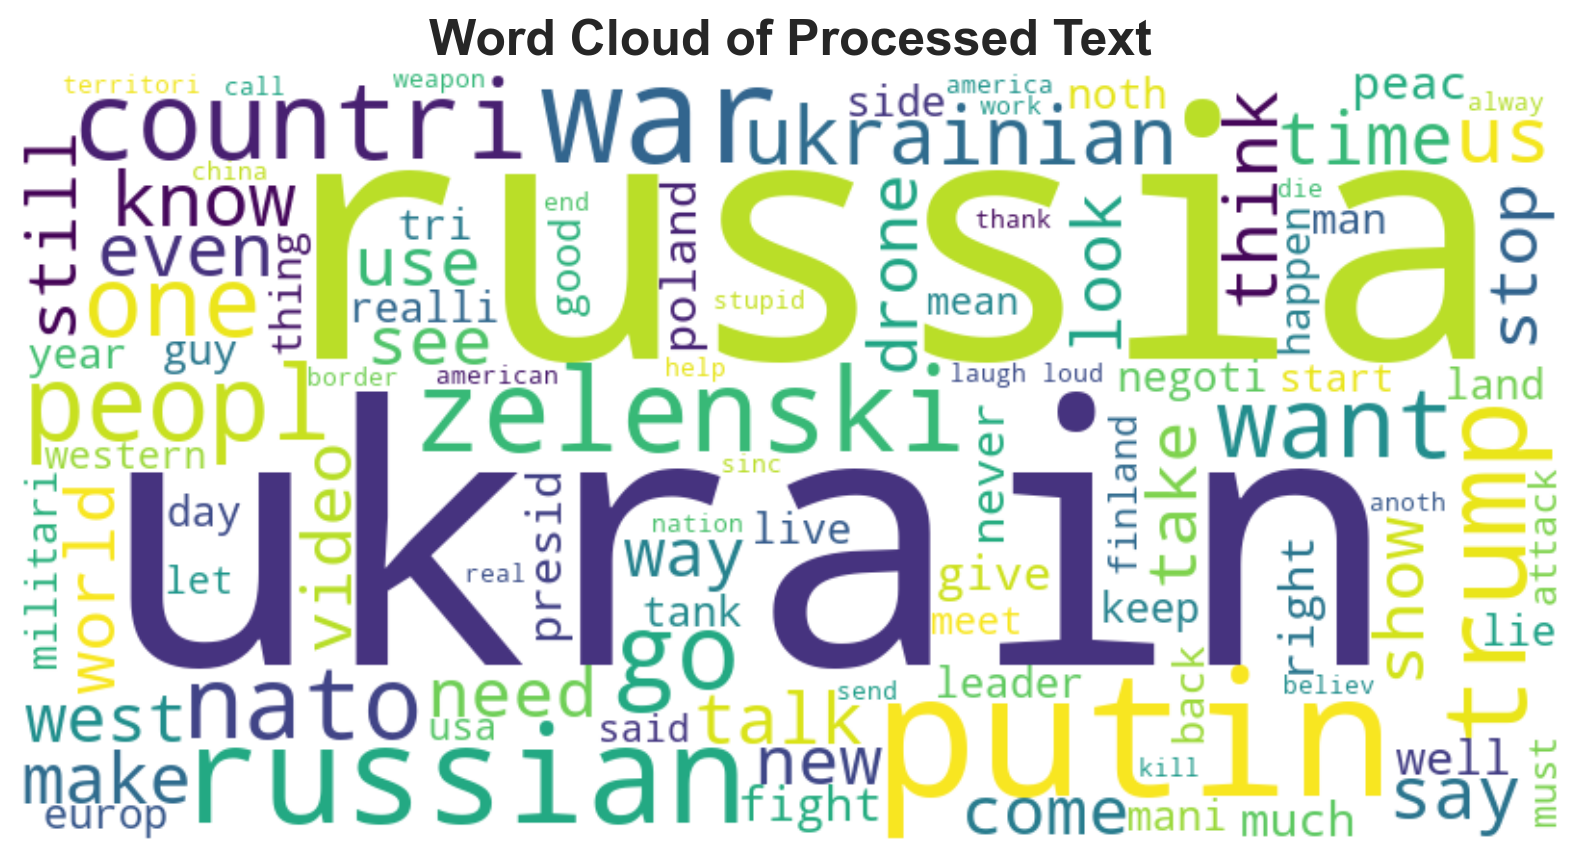

In [15]:

# Generate word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join(df['clean_text_filtered'])
wordcloud = WordCloud(width=800, height=400, 
                     background_color='white',
                     max_words=100).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Processed Text")
plt.show()


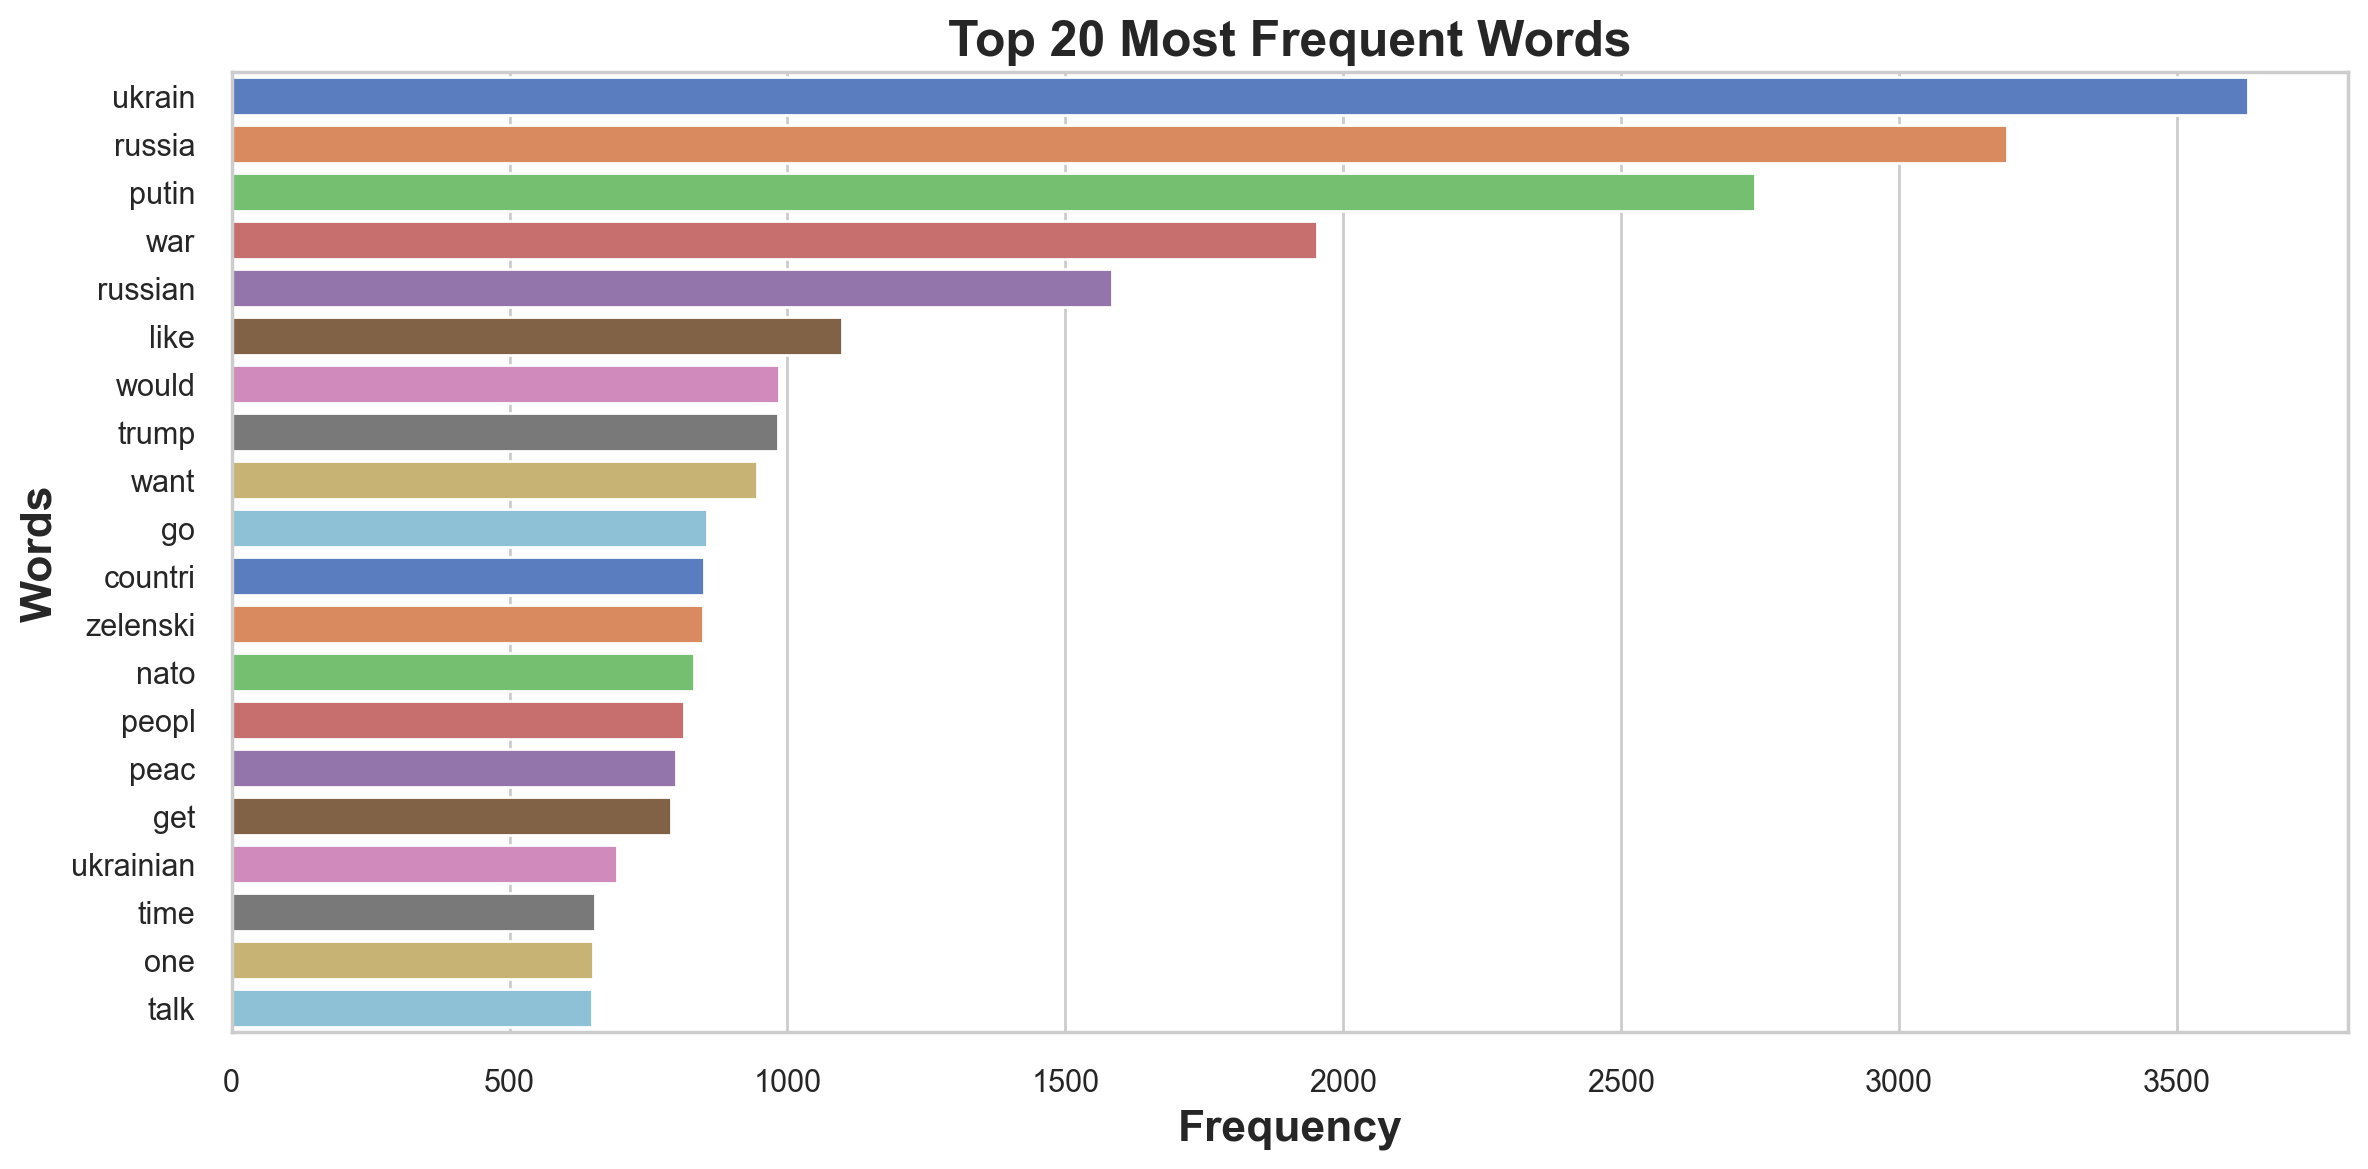

In [16]:

# Show top 20 most common words
top_words = word_freq.most_common(20)
words, counts = zip(*top_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=counts, y=words, palette='muted', hue=words, orient='horizontal')
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel('Words')
plt.tight_layout()
plt.show()




In [ ]:
# Initializing VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Applying VADER sentiment scoring
df["sentiment_score"] = df["clean_text_filtered"].apply(lambda x: sid.polarity_scores(x)["compound"])


def classify_sentiment(score):
    if score >= 0.02:    # More lenient for Positive
        return "Positive"
    elif score <= -0.02: # More lenient for Negative
        return "Negative"
    return "Neutral"

# Apply classification
df["sentiment"] = df["sentiment_score"].apply(classify_sentiment)

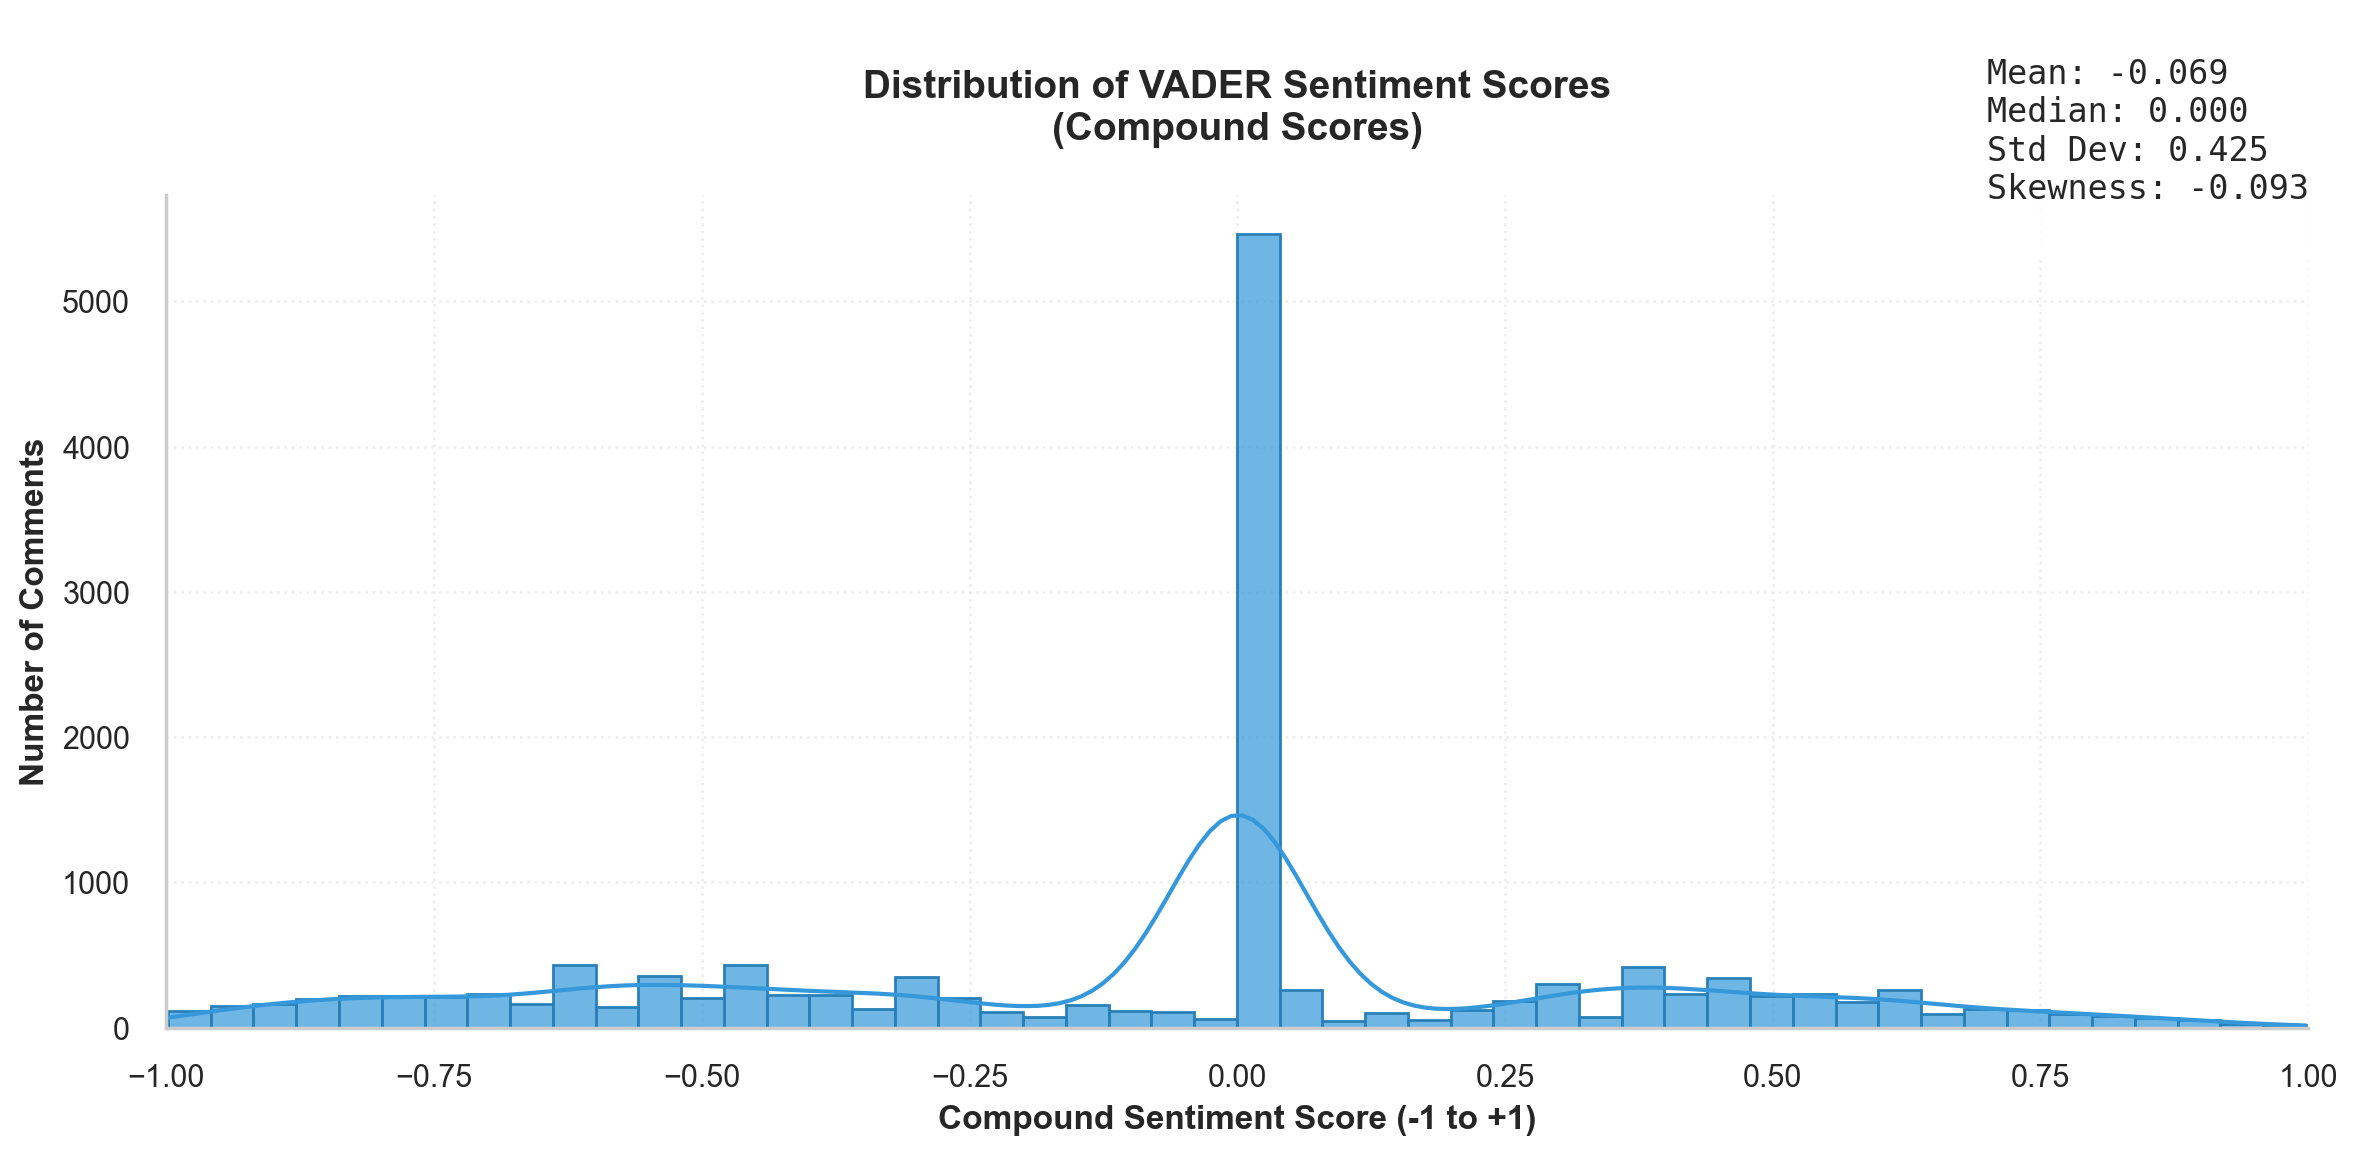

In [31]:
# Set up the figure
plt.figure(figsize=(12, 6))

# Create distribution plot
ax = sns.histplot(df['sentiment_score'], 
                 bins=50, 
                 kde=True,
                 color='#3498db',
                 edgecolor='#2980b9',
                 alpha=0.7)


# Formatting
plt.title('Distribution of VADER Sentiment Scores\n(Compound Scores)', 
         fontsize=14, pad=20)
plt.xlabel('Compound Sentiment Score (-1 to +1)', fontsize=12)
plt.ylabel('Number of Comments', fontsize=12)
plt.xlim(-1, 1)
plt.grid(True, linestyle=':', alpha=0.3)

# Add statistics box
stats_text = f"""
Mean: {df['sentiment_score'].mean():.3f}
Median: {df['sentiment_score'].median():.3f}
Std Dev: {df['sentiment_score'].std():.3f}
Skewness: {df['sentiment_score'].skew():.3f}
"""
plt.text(0.85, 0.95, stats_text, 
         transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         fontfamily='monospace')

sns.despine()
plt.tight_layout()
plt.show()

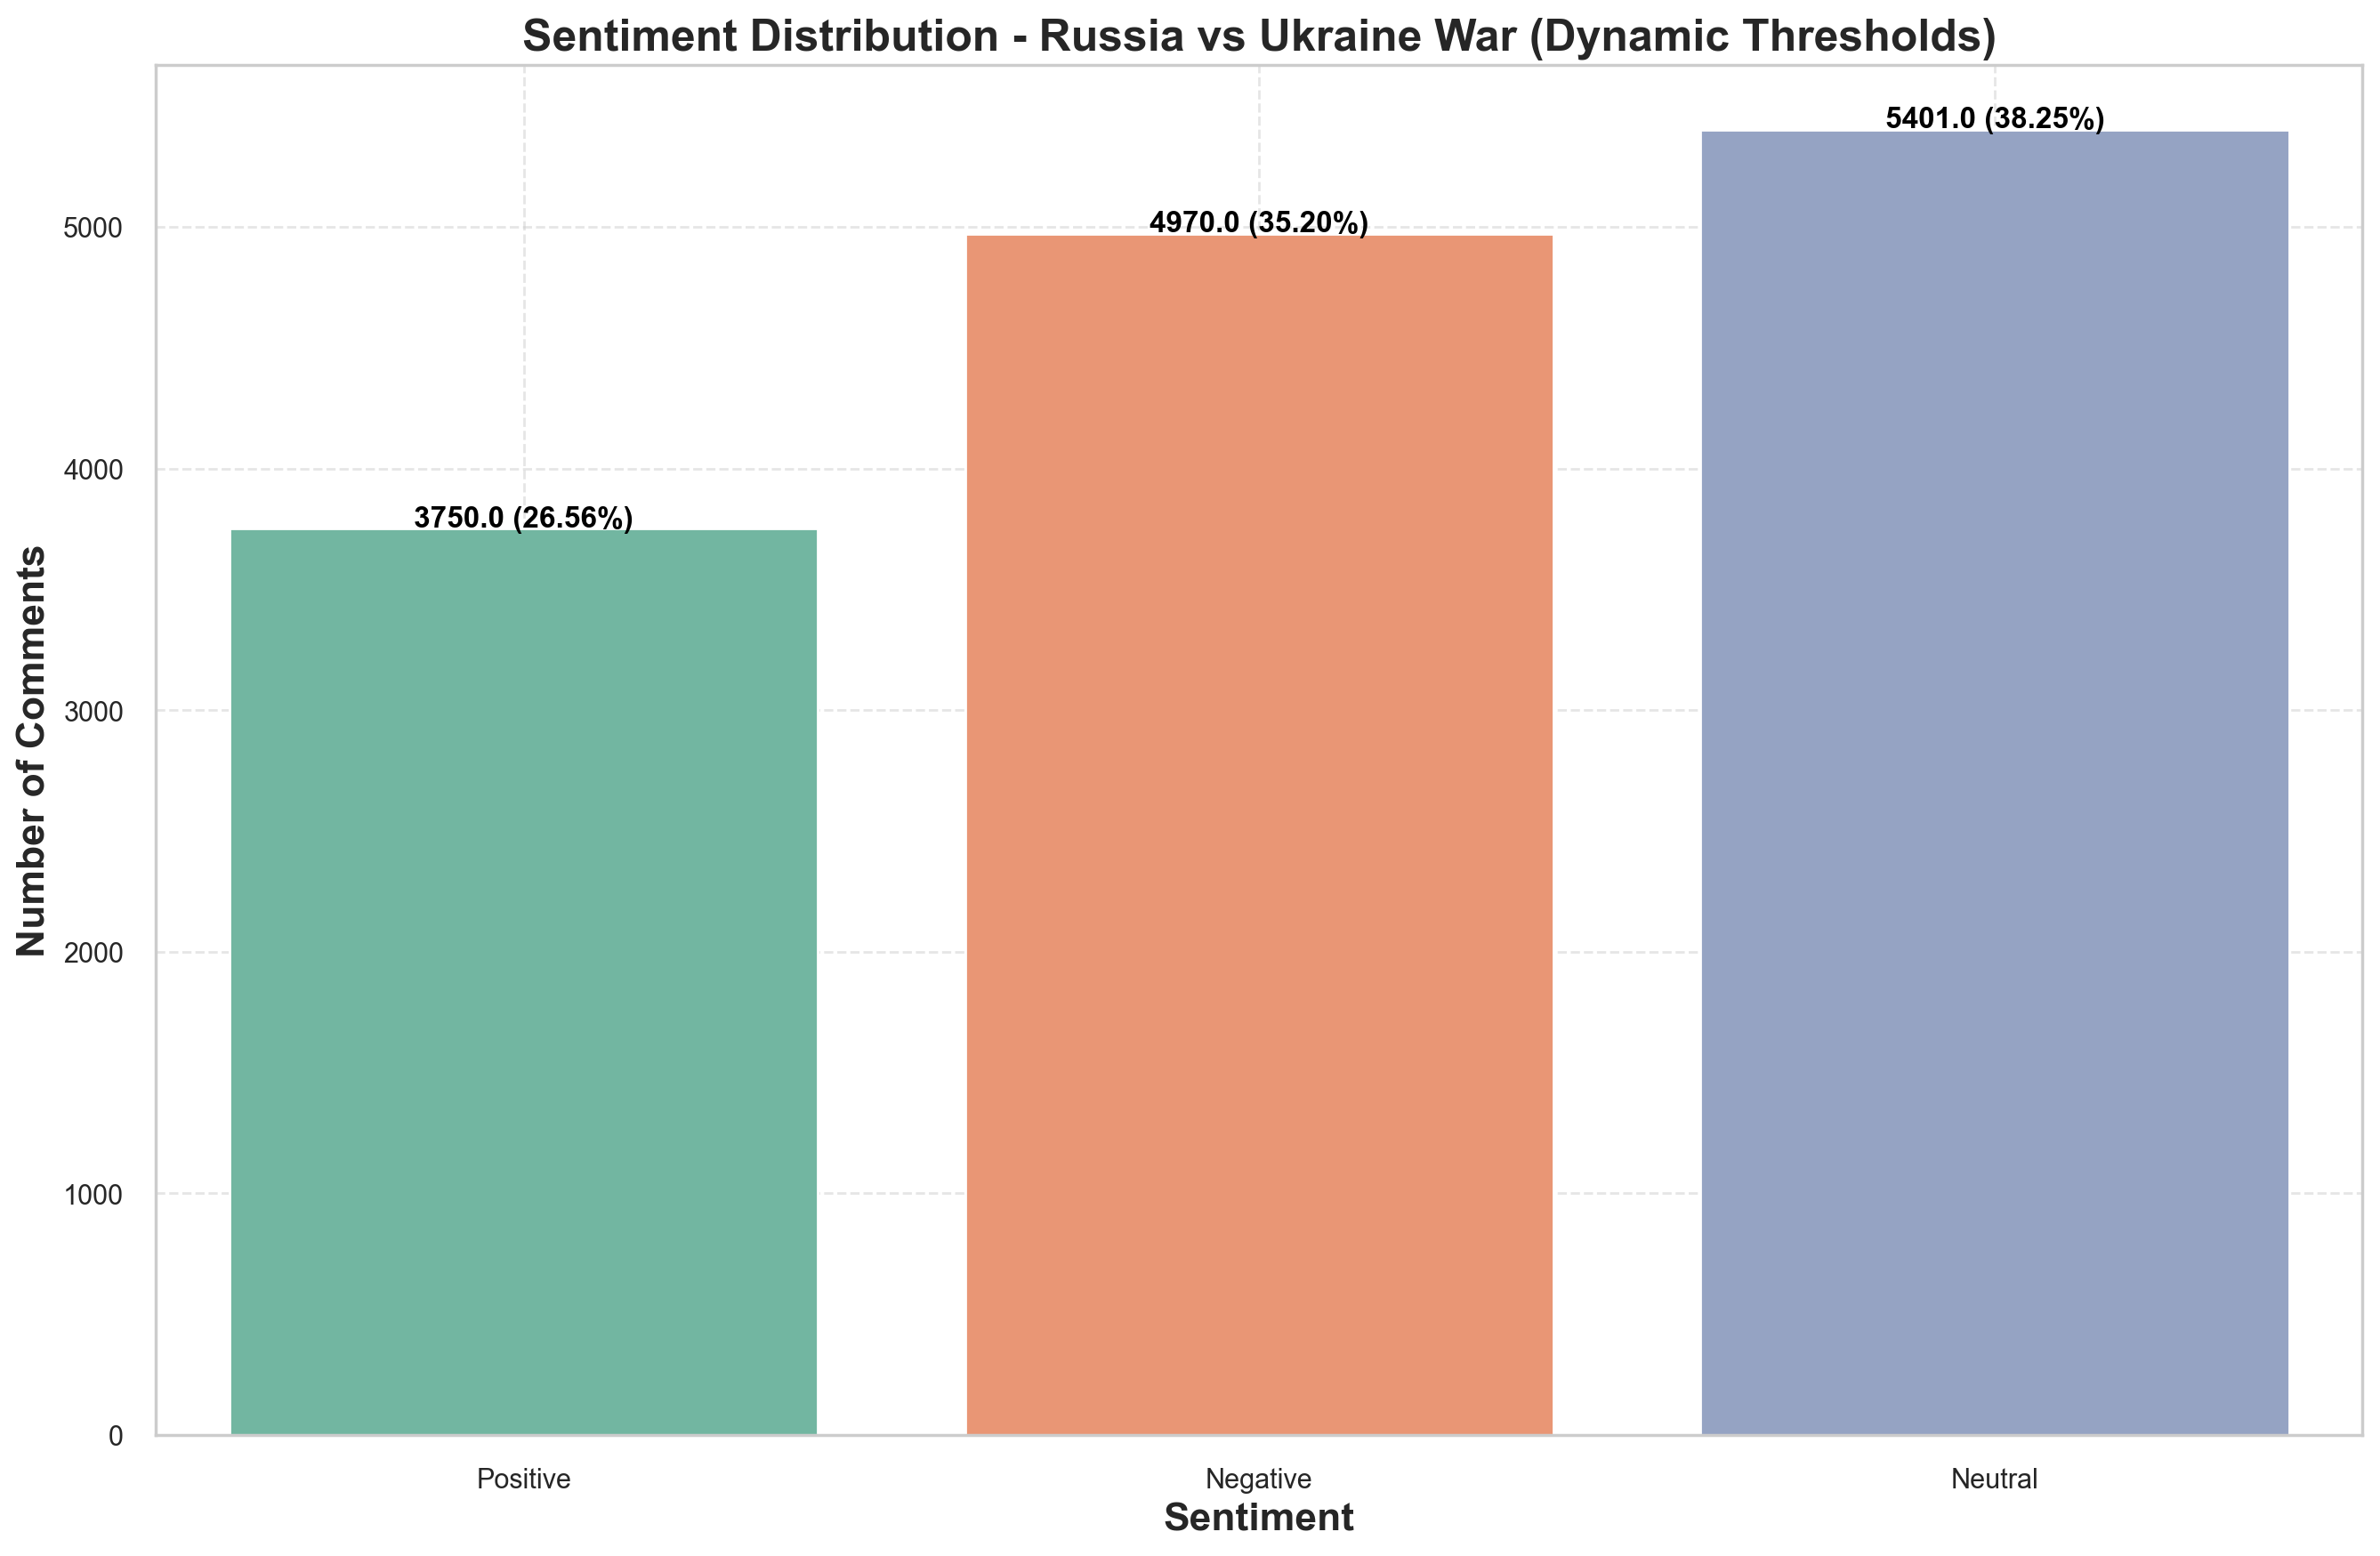

In [26]:
ax = sns.countplot(data=df, x='sentiment', palette='Set2', hue='sentiment')
plt.title("Sentiment Distribution - Russia vs Ukraine War (Dynamic Thresholds)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.grid(True, linestyle="--", alpha=0.5)
total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(p.get_x() + p.get_width() / 2, height + 10, f'{height} ({percentage:.2f}%)',
            ha='center', fontweight='bold', color='black')
plt.show()

In [33]:
# Initilizing the corpus for LDA
corpus = df["clean_text_filtered"].tolist()

# Parameters for LDA and Vectorizers
min_df = 5
n_topics = 6
max_df = 0.95           
max_iter = 25
n_top_words = 10
max_features = 2000
seed_value = 999

# Function to print topics
def print_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Function to display word clouds for each topic
def display_word_cloud(model, feature_names, sup_title):
    normalised_components = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    topic_num = len(model.components_)
    col_num = 3
    row_num = int(math.ceil(topic_num / col_num))
    for topic_id, l_topic_dist in enumerate(normalised_components):
        l_word_prob = {feature_names[i]: _word_prob for i, _word_prob in enumerate(l_topic_dist)}
        wordcloud = WordCloud(background_color='black').generate_from_frequencies(l_word_prob)
        plt.subplot(row_num, col_num, topic_id + 1)
        plt.suptitle(sup_title, fontsize=20, fontweight='bold')
        plt.title(f'Topic {topic_id + 1}')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Initializing LDA model
base_lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=max_iter,
    random_state=seed_value,
    learning_method='online' # for large datasets
)

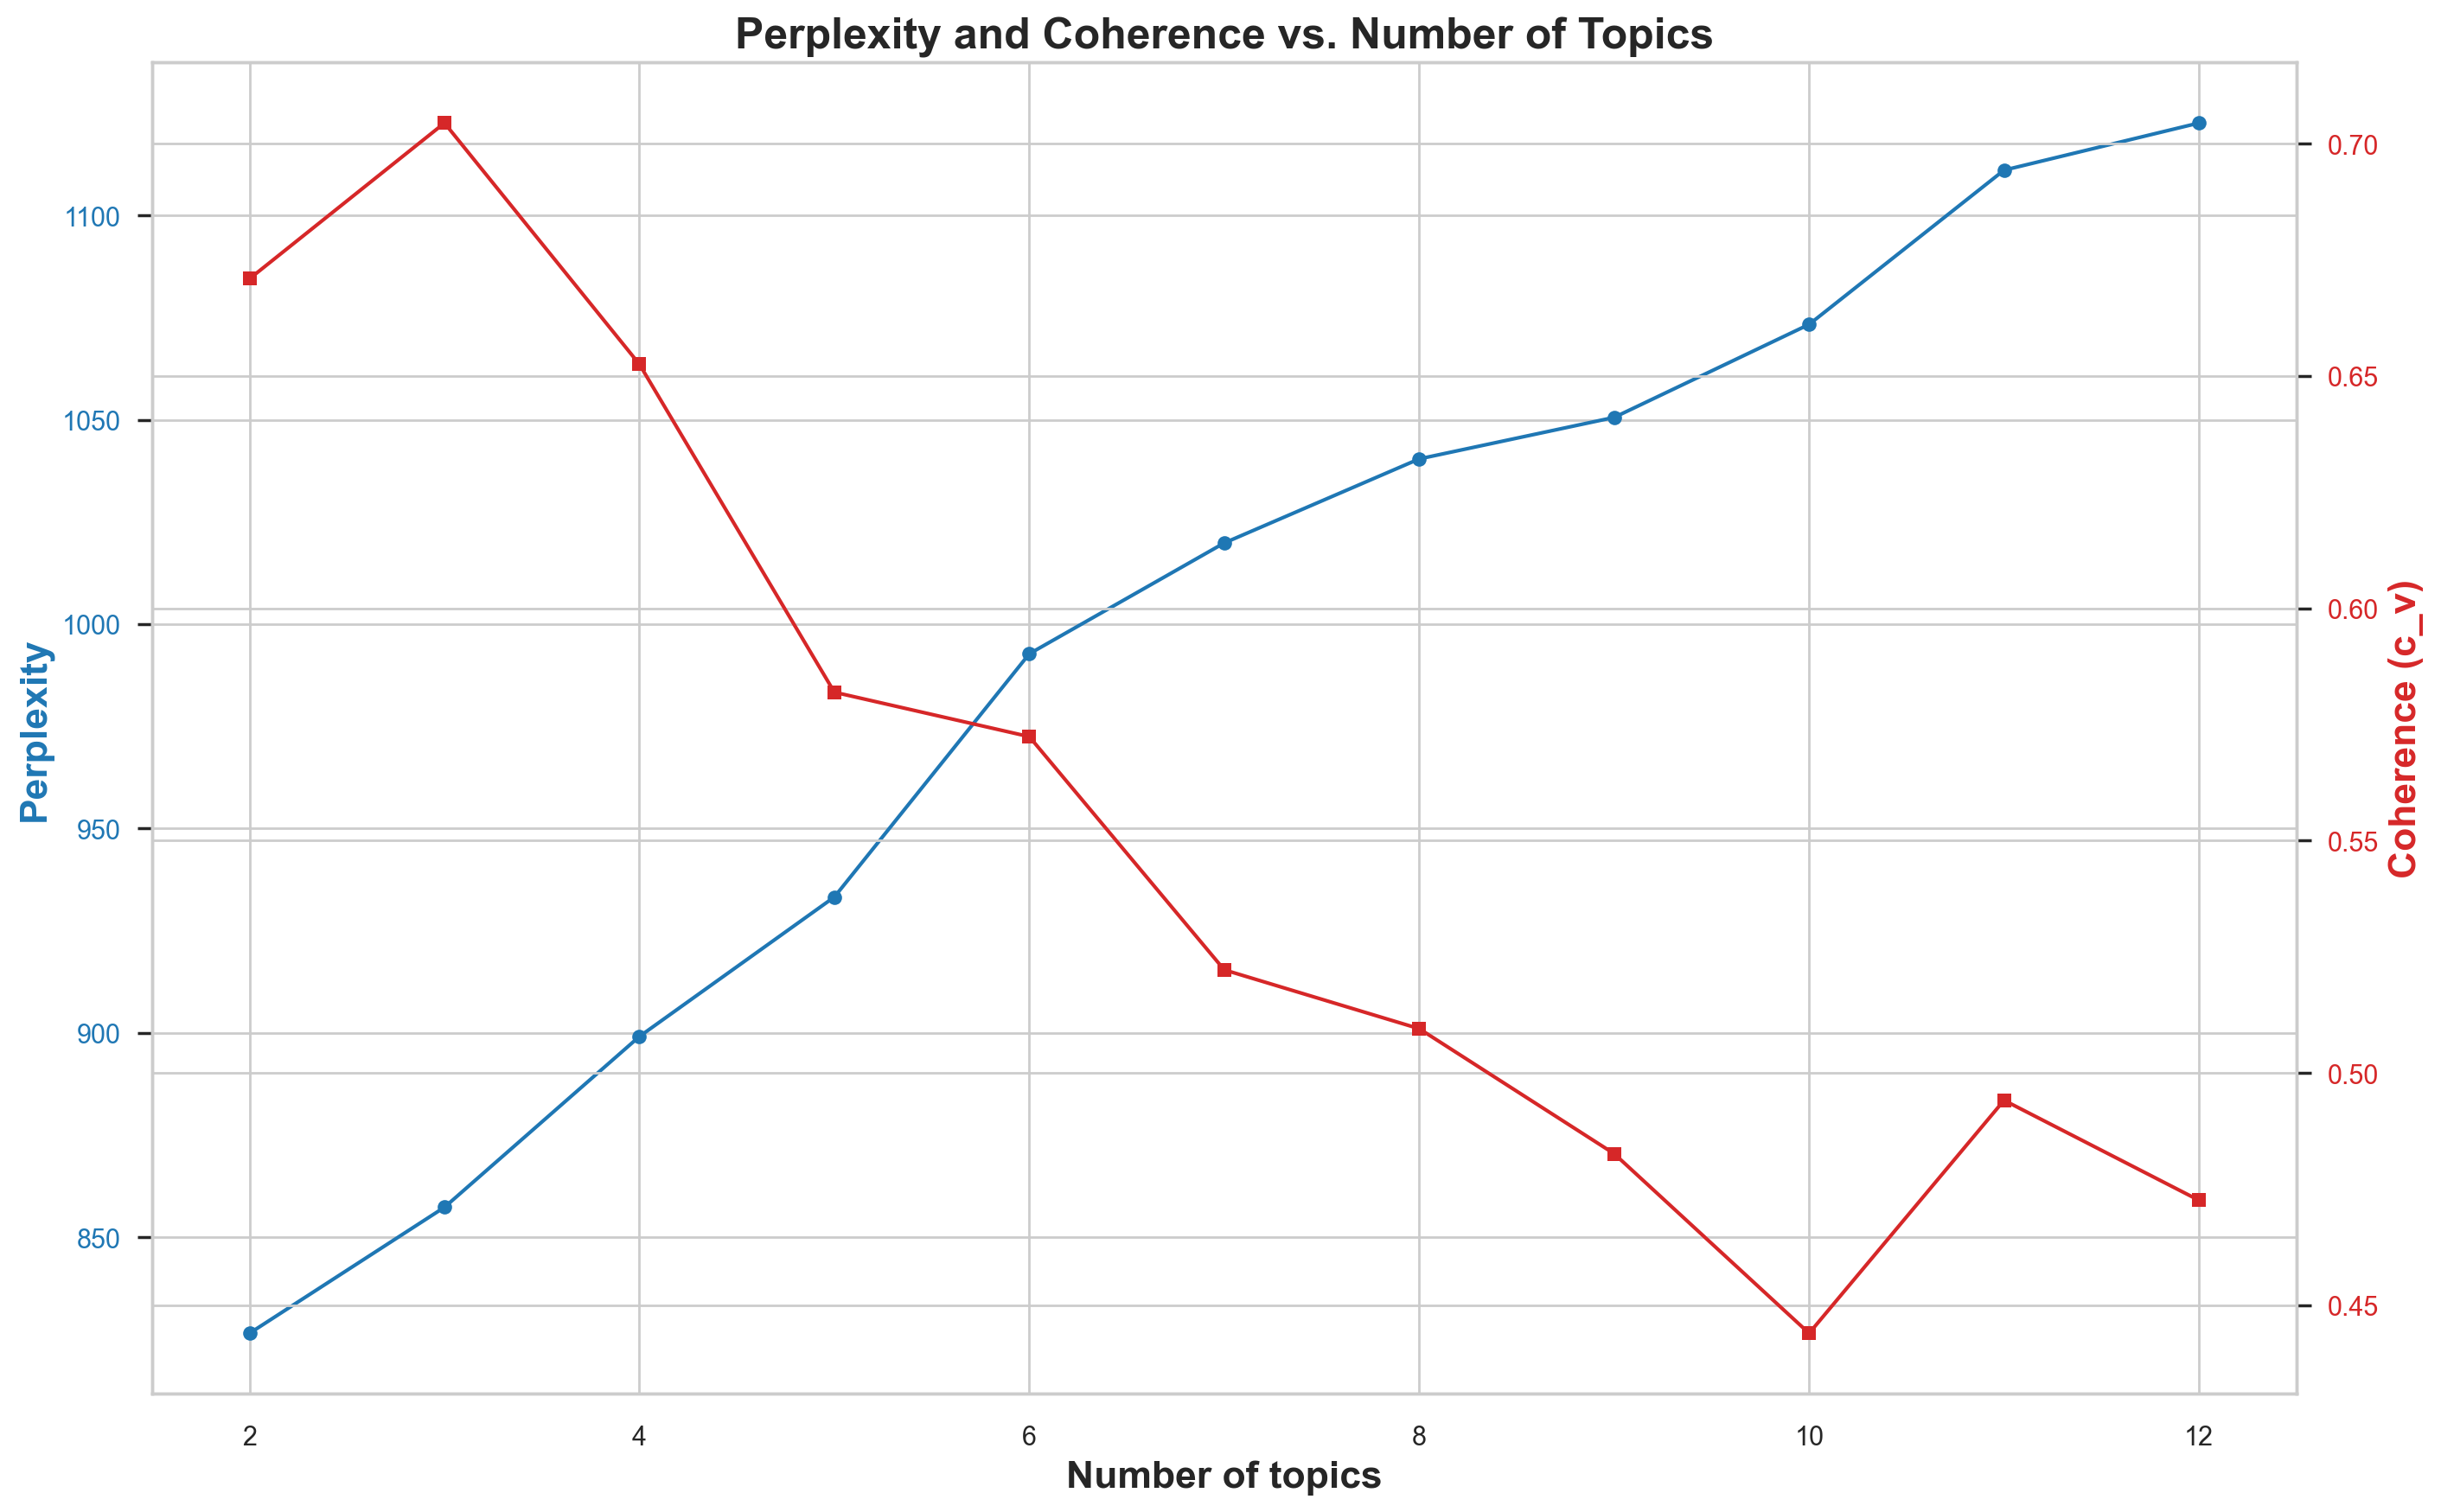

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim

# 1. Prepare document-term matrix (you’ve already done this as `topic_fit_count_vec`)
count_vec = CountVectorizer(max_df=0.95,
                            min_df=5,
                            stop_words='english',
                            lowercase=True,
                            max_features=2000)
X = count_vec.fit_transform(corpus)
feature_names = count_vec.get_feature_names_out()

# 2. Build Gensim corpus and dictionary for coherence
texts = [doc.split() for doc in corpus]
dictionary = Dictionary(texts)
gensim_corpus = [dictionary.doc2bow(text) for text in texts]

# 3. Sweep over number of topics
topic_range = range(2, 13)   # try from 2 up to 12 topics
perplexities = []
coherence_scores = []

for k in topic_range:
    # fit sklearn LDA
    lda = LatentDirichletAllocation(
        n_components=k,
        max_iter=25,
        learning_method='online',
        random_state=999
    ).fit(X)

    # 3a. record perplexity (lower = better fit of model to data)
    perplexities.append(lda.perplexity(X))

    # 3b. extract top-words per topic for coherence
    topics = []
    for comp in lda.components_:
        top_indices = comp.argsort()[:-10-1:-1]        # top-10 words
        topics.append([feature_names[i] for i in top_indices])

    # 3c. compute c_v coherence
    cm = CoherenceModel(
        topics=topics,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_scores.append(cm.get_coherence())

# 4. Plot both metrics
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of topics')
ax1.set_ylabel('Perplexity', color=color)
ax1.plot(topic_range, perplexities, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Coherence (c_v)', color=color)
ax2.plot(topic_range, coherence_scores, marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Perplexity and Coherence vs. Number of Topics')
plt.show()


In [37]:
# Initialize CountVectorizer for LDA
count_vec = CountVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words='english',
    lowercase=True,
    max_features=max_features
)

# Fitting CountVectorizer to the corpus
topic_fit_count_vec = count_vec.fit_transform(corpus)
feature_names_count = count_vec.get_feature_names_out()

# Fitting LDA model with CountVectorizer
lda_model_count_vec = base_lda_model
lda_model_count_vec.fit(topic_fit_count_vec)

# Displaying Topics for LDA model with CountVectorizer
print_topics(lda_model_count_vec, feature_names_count, n_top_words)

# Visualizing Topics for CountVectorizer using pyLDAvis
pyLDAvis.enable_notebook()
panel =  pyLDAvis.lda_model.prepare(lda_model_count_vec, topic_fit_count_vec, count_vec, mds='tsne')
pyLDAvis.display(panel)


Topic #1:
putin, russia, ukrain, trump, war, want, countri, world, nato, stop

Topic #2:
ukrain, think, use, drone, russian, tank, russia, good, territori, parad

Topic #3:
zelenski, talk, presid, way, end, peac, negoti, laugh, let, meet

Topic #4:
poland, troop, ukrain, ukrainian, nation, mean, state, western, send, ago

Topic #5:
like, russian, fight, peopl, border, usa, soldier, look, die, mani

Topic #6:
ukrain, russia, war, russian, know, video, like, militari, win, land
